In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from pyspark.sql.types import *
spark =SparkSession.builder \
  .master('local[*]') \
  .appName('conversions') \
  .config('spark.jars.packages', 'com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.23.2') \
  .getOrCreate() 
sqlContext = SQLContext(spark)

:: loading settings :: url = jar:file:/usr/lib/spark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.google.cloud.spark#spark-bigquery-with-dependencies_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-ebbf1e43-20f0-4e37-91e2-7befc79d29e6;1.0
	confs: [default]
	found com.google.cloud.spark#spark-bigquery-with-dependencies_2.12;0.23.2 in central
:: resolution report :: resolve 327ms :: artifacts dl 5ms
	:: modules in use:
	com.google.cloud.spark#spark-bigquery-with-dependencies_2.12;0.23.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   1   |   0   |   0   |   0   ||   1   |   0   |
	---------------------------------------------------------------------
:: retrie

In [2]:
df = (spark.read.format('bigquery').option('table', 'nftSales.nft-Sales')
                        .option('header' , 'true')
                        .option("inferSchema", "true")
                        .load())

In [3]:
df.show(5)
df.printSchema()

+----------+----------------+----------------------+----------------------------+--------------------+----------------------+--------------+--------------------+---------------+---------------------+-------------+
|      Date|Sales_USD_cumsum|Number_of_Sales_cumsum|Active_Market_Wallets_cumsum|Primary_Sales_cumsum|Secondary_Sales_cumsum|AverageUSD_cum|           Sales_USD|Number_of_Sales|Active_Market_Wallets|Primary_Sales|
+----------+----------------+----------------------+----------------------------+--------------------+----------------------+--------------+--------------------+---------------+---------------------+-------------+
|2017-06-22|             0.0|                     0|                         0.0|                   0|                  null|          null|                 0.0|           null|                 null|         null|
|2021-11-05|    9890101769.5|              10691247|                        null|             6398169|                7019.0|        925.07|3.09

In [4]:
import numpy as np,pandas as pd, matplotlib.pyplot as plt
import math
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

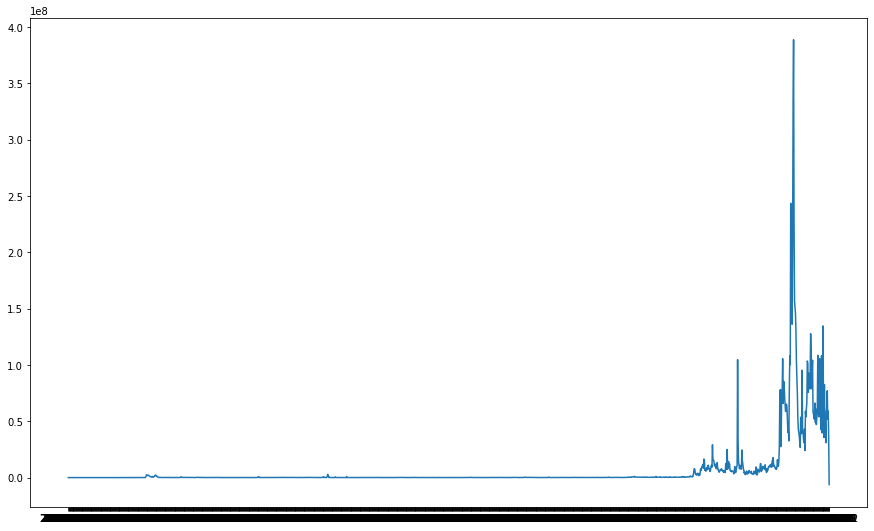

In [5]:
date = df.sort("Date").select('Date').toPandas()['Date']
sales = df.sort("Date").select('Sales_USD').toPandas()['Sales_USD']
plt.figure(figsize=(15,9))
plt.plot(date, sales)
plt.show()

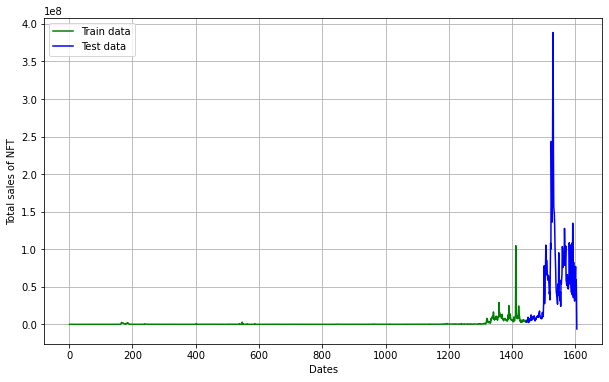

In [6]:
#Train test split
to_row = int(df.count()*0.90)
remaining = df.count() - to_row
training_data =  list(df.sort("Date").select('Date','Sales_USD').toPandas()['Sales_USD'][1:to_row])
testing_data = list(df.sort("Date").select('Date','Sales_USD').toPandas()['Sales_USD'][to_row:])
#print(testing_data)
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Total sales of NFT')
plt.plot(df.sort("Date").select('Date','Sales_USD').toPandas()['Sales_USD'][1:to_row], 'green', label='Train data')
plt.plot(df.sort("Date").select('Date','Sales_USD').toPandas()['Sales_USD'][to_row:], 'blue', label='Test data')
plt.legend()

In [7]:
model_predictions = []
n_test_obser = len(testing_data)
#print(testing_data)
print(n_test_obser)

161


In [8]:
for i in range(n_test_obser):
  #model = ARIMA(training_data, order = (4,1,0))
  #model = ARIMA(training_data, order = (1,0,5))
  model = ARIMA(training_data, order = (4,1,0))
  model_fit = model.fit()
  output = model_fit.forecast()
  #print(output[0])  
  yhat = output[0]
  model_predictions.append(yhat)
  actual_test_value = testing_data[i]
  training_data.append(actual_test_value) # inorder to update training data in real time for future predictions 
  #print(output)
  #break
#yhat is the predicated value from teh result
#list(output[0])[0]


In [9]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1604
Model:                 ARIMA(4, 1, 0)   Log Likelihood              -28053.265
Date:                Wed, 20 Apr 2022   AIC                          56116.529
Time:                        06:02:47   BIC                          56143.428
Sample:                             0   HQIC                         56126.517
                               - 1604                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1368      0.005    -24.905      0.000      -0.148      -0.126
ar.L2         -0.3162      0.006    -54.292      0.000      -0.328      -0.305
ar.L3         -0.1204      0.006    -19.977      0.0

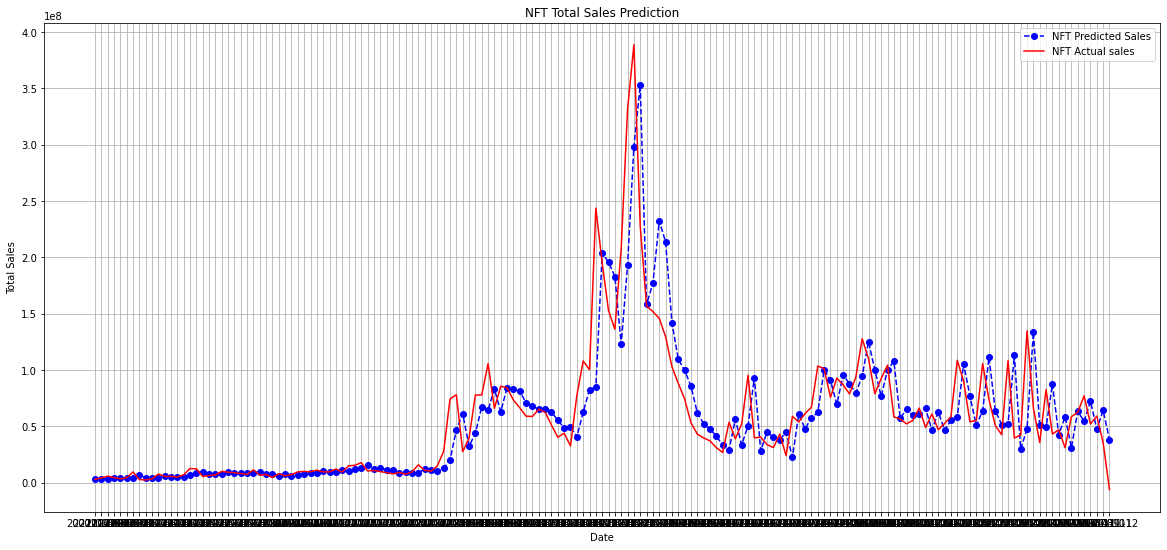

In [10]:
plt.figure(figsize=(20,9))
plt.grid(True)
#print(df.select('Date','Sales_USD').toPandas()['Date'][to_row:])
date_range = df.sort("Date").select('Date','Sales_USD').toPandas()['Date'][to_row:]
plt.plot(date_range, model_predictions, color = "blue", marker = 'o', linestyle = 'dashed', label = 'NFT Predicted Sales')
plt.plot(date_range, testing_data, color = "red", label = 'NFT Actual sales')
plt.title('NFT Total Sales Prediction')
plt.xlabel('Date')
plt.ylabel('Total Sales')

plt.legend()
plt.show()

In [11]:
# report performance
#print(np.array(model_predictions[:-1])
mape = np.mean(np.abs(np.array(model_predictions) - np.array(testing_data))/np.abs(testing_data))
print('MAPE :'+str(mape)) # Mean Absolute percentage error

MAPE :0.36957332303160334
